# 와인 분류 문제(레드/화이트 와인)
- 📝 Tistory: https://heytech.tistory.com/
- 💻 Github: https://github.com/park-gb/

# 라이브러리 import

In [1]:
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리

In [2]:
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리

In [3]:
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# 데이터 불러오기

In [4]:
# 레드 와인데이터셋 불러오기
red = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')
# 화이트 와인데이터셋 불러오기
white = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', sep=';')

In [5]:
red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
white.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


# 데이터 전처리

## 불필요한 변수 제거

In [7]:
# 일반적으로 와인 퀄리티가 와인의 종류를 구분하지 않기 때문에 quality 변수 제거
red = red.drop(['quality'], axis = 1)
white = white.drop(['quality'], axis = 1)

## 결측치 처리

In [8]:
red.isnull().sum() # 결측치 미존재

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [9]:
white.isnull().sum() # 결측치 미존재

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

## 이상치 처리
- 와인 종류별로 데이터 분포가 다르기 때문에 이상치 역시 따로 처리해야 함

### Boxplot을 활용한 이상치 확인

In [10]:
def boxplot_vis(data, target_name):
    plt.figure(figsize=(30, 30))
    for col_idx in range(len(data.columns)):
        # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
        plt.subplot(6, 2, col_idx+1)
        # flierprops: 빨간색 다이아몬드 모양으로 아웃라이어 시각화
        plt.boxplot(data[data.columns[col_idx]], flierprops = dict(markerfacecolor = 'r', marker = 'D'))
        # 그래프 타이틀: feature name
        plt.title("Feature" + "(" + target_name + "):" + data.columns[col_idx], fontsize = 20)
    plt.savefig('../figure/boxplot_' + target_name + '.png')
    plt.show()

### 이상치 제거

In [11]:
def remove_outlier(input_data):
    q1 = input_data.quantile(0.25) # 제 1사분위수
    q3 = input_data.quantile(0.75) # 제 3사분위수
    iqr = q3 - q1 # IQR(Interquartile range) 계산
    minimum = q1 - (iqr * 1.5) # IQR 최솟값
    maximum = q3 + (iqr * 1.5) # IQR 최댓값
    # IQR 범위 내에 있는 데이터만 산출(IQR 범위 밖의 데이터는 이상치)
    df_removed_outlier = input_data[(minimum < input_data) & (input_data < maximum)]
    return df_removed_outlier

#### 레드와인 이상치 처리

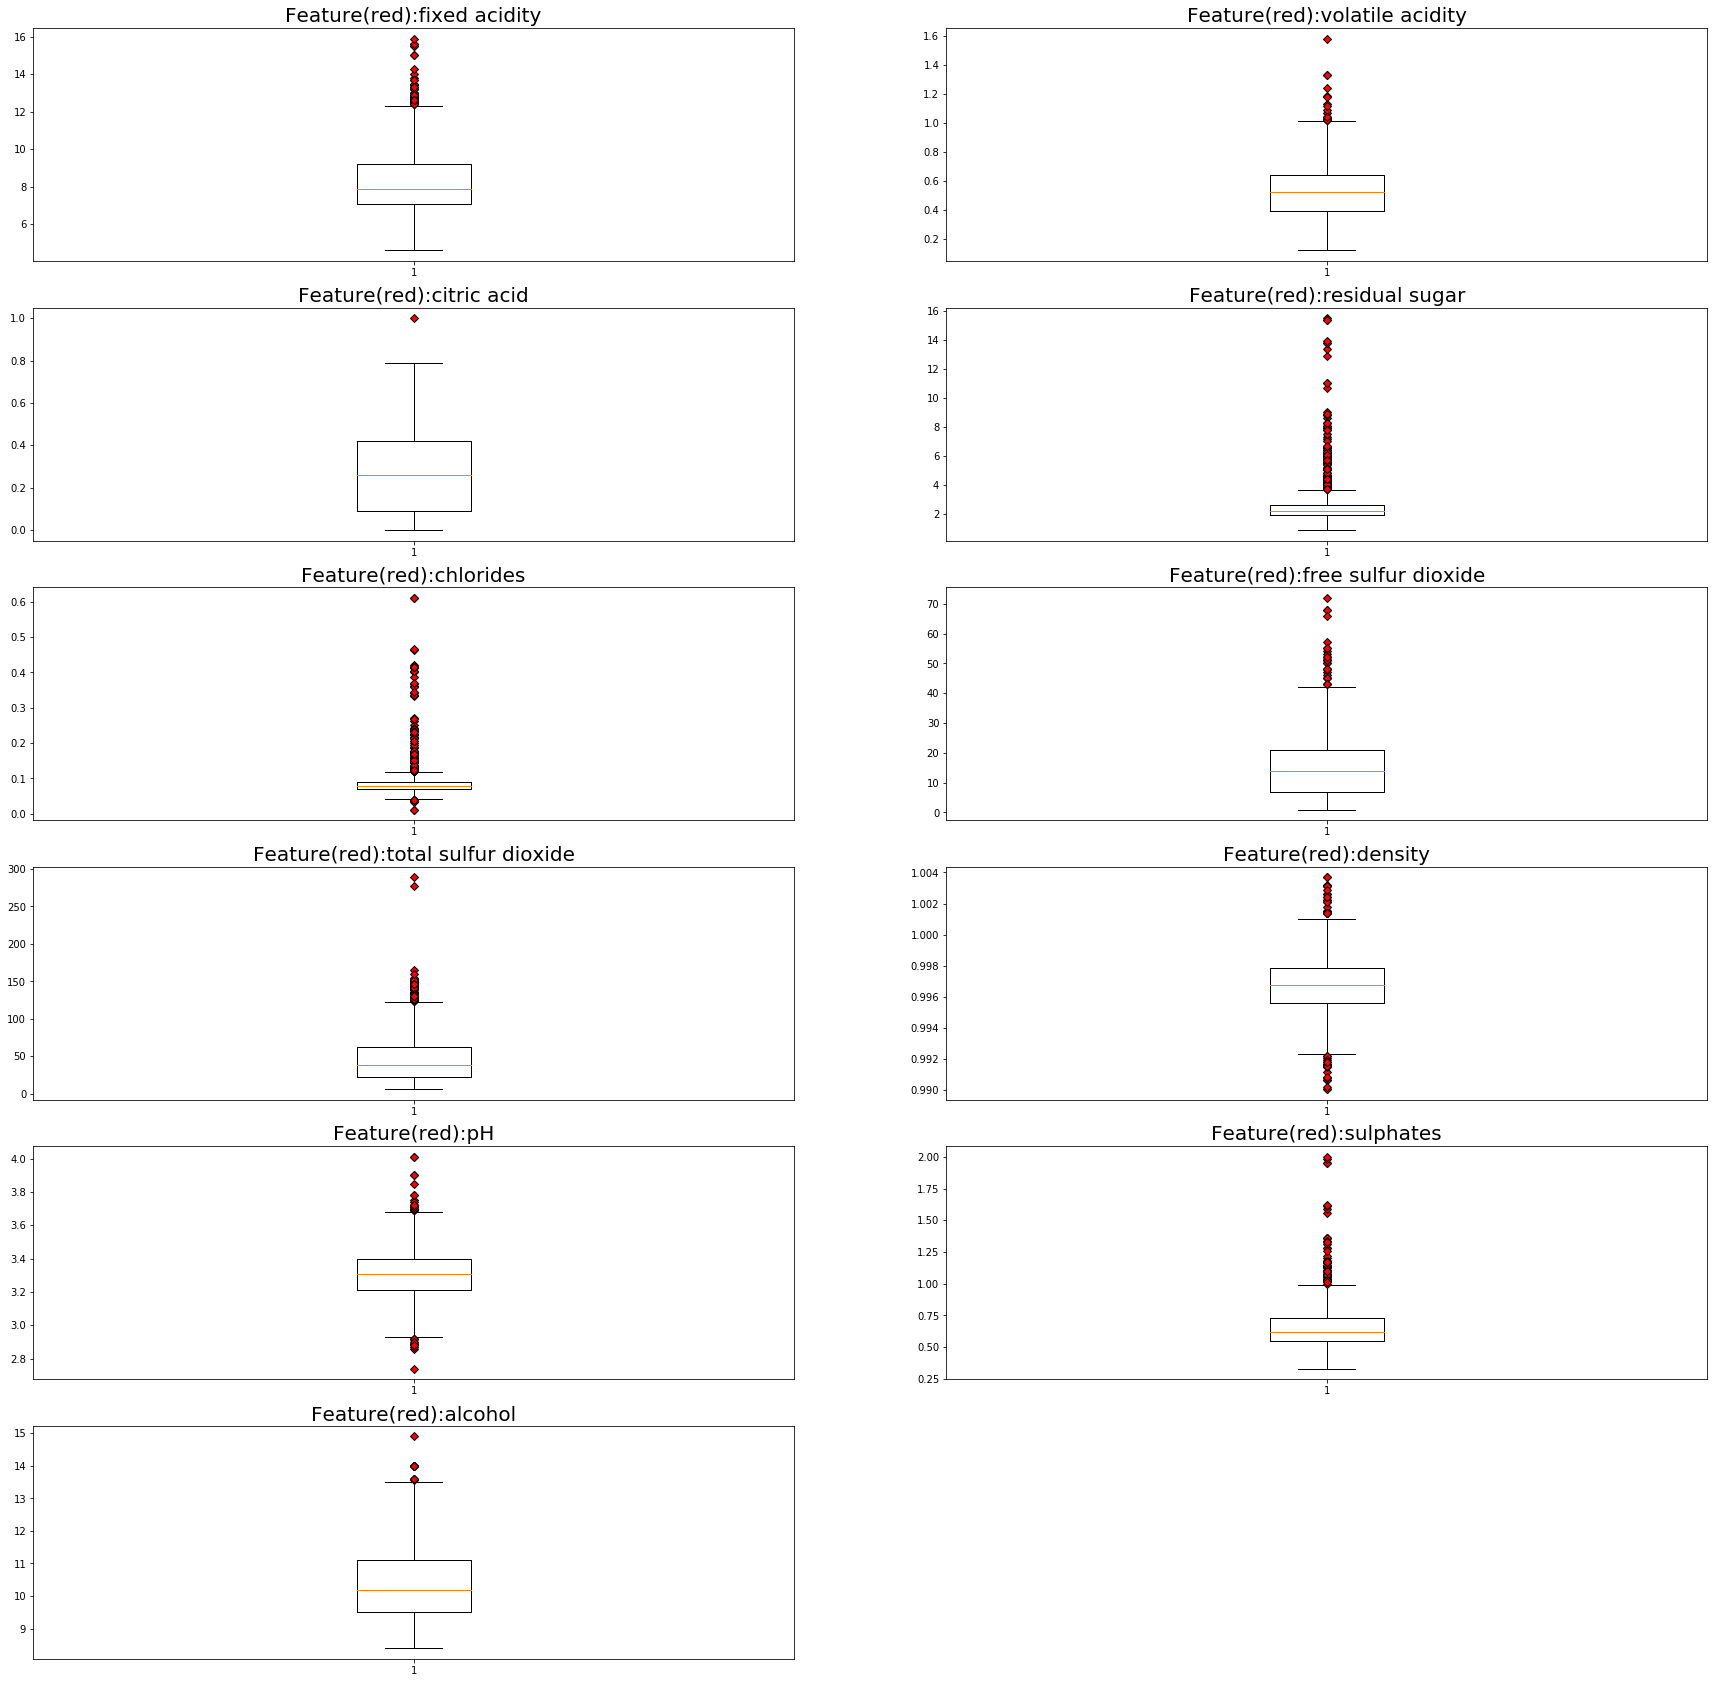

In [12]:
boxplot_vis(red, 'red')

In [13]:
# 이상치 제거한 데이터셋
red_prep = remove_outlier(red)

In [14]:
# 목표변수 할당
red_prep['target'] = 0

In [15]:
# 결측치(이상치 처리된 데이터) 확인
red_prep.isnull().sum()

fixed acidity            49
volatile acidity         19
citric acid               1
residual sugar          155
chlorides               112
free sulfur dioxide      33
total sulfur dioxide     58
density                  45
pH                       35
sulphates                59
alcohol                  14
target                    0
dtype: int64

In [16]:
# 이상치 포함 데이터(이상치 처리 후 NaN) 삭제
red_prep.dropna(axis = 0, how = 'any', inplace = True)
print(f"이상치 포함된 데이터 비율: {round((len(red) - len(red_prep))*100/len(red), 2)}%")

이상치 포함된 데이터 비율: 25.58%


#### 화이트 와인 이상치 처리

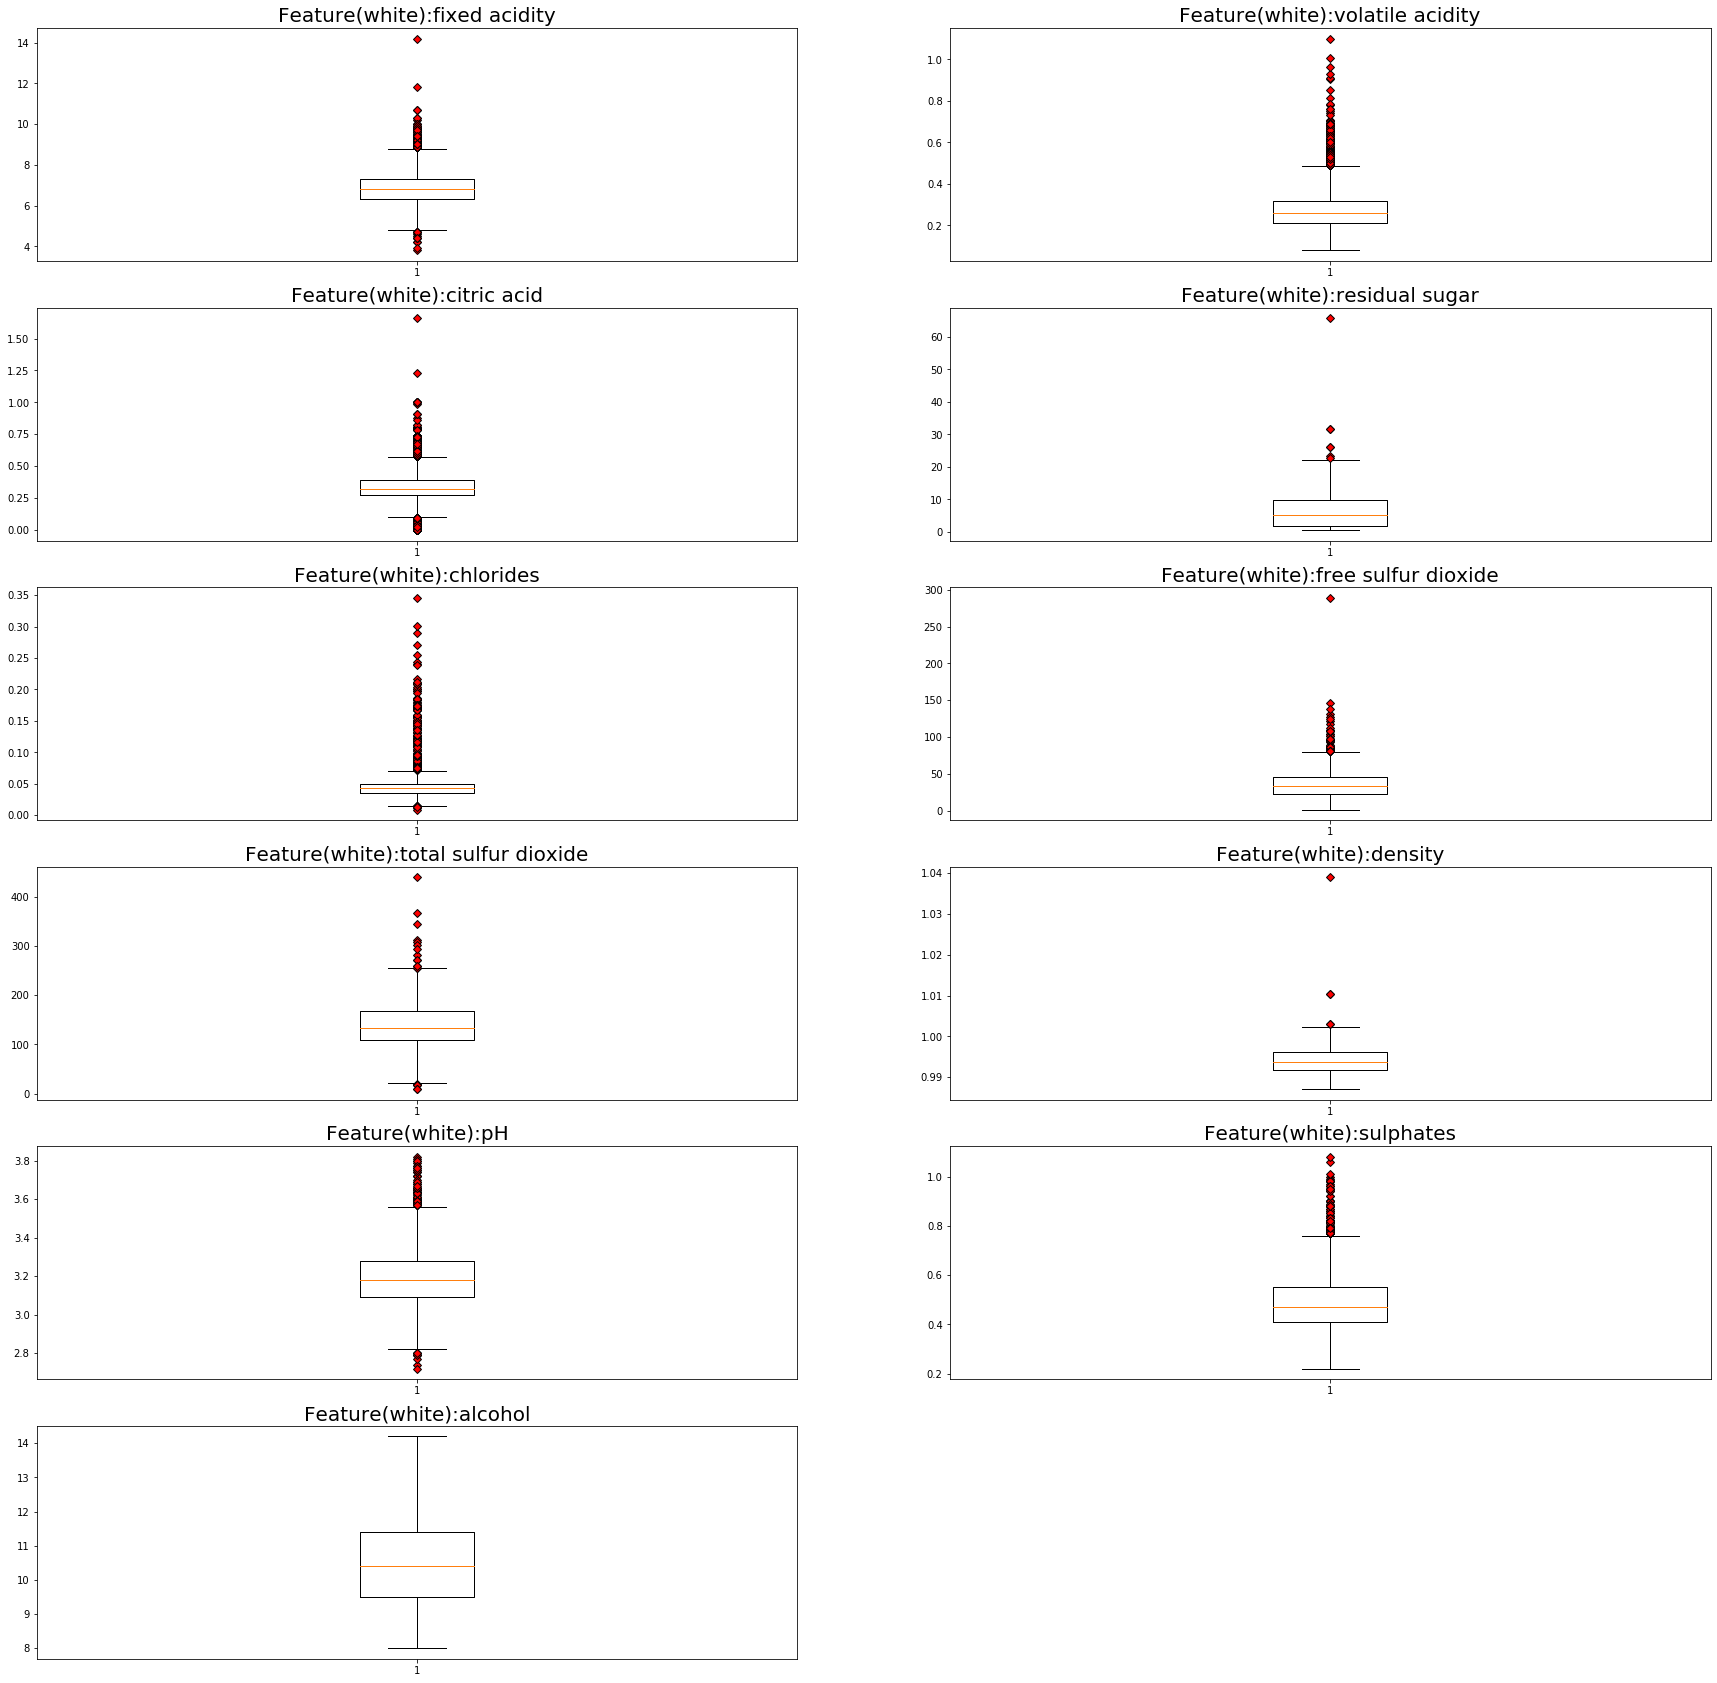

In [17]:
boxplot_vis(white, 'white')

In [18]:
# 이상치 제거한 데이터셋
white_prep = remove_outlier(white)

In [19]:
# 목표변수 할당
white_prep['target'] = 1

In [20]:
# 결측치(이상치 처리된 데이터) 확인
white_prep.isnull().sum()

fixed acidity           146
volatile acidity        186
citric acid             270
residual sugar            7
chlorides               208
free sulfur dioxide      50
total sulfur dioxide     19
density                   5
pH                       75
sulphates               124
alcohol                   0
target                    0
dtype: int64

In [21]:
# 이상치 포함 데이터(이상치 처리 후 NaN) 삭제
white_prep.dropna(axis = 0, how = 'any', inplace = True)
print(f"이상치 포함된 데이터 비율: {round((len(white) - len(white_prep))*100/len(white), 2)}%")

이상치 포함된 데이터 비율: 18.37%


## 데이터 저장

In [22]:
# 데이터셋 저장
red_prep.to_csv('../dataset/red_prep.csv')
white_prep.to_csv('../dataset/white_prep.csv')

# 데이터 병합

In [23]:
# 레드 와인, 화이트 와인 데이터셋 병합
df = pd.concat([red_prep, white_prep], axis = 0)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [24]:
df.to_csv('../dataset/wine_combined.csv')

In [25]:
# 화이트 와인이 레드와인보다 약 3.5배 더 많음
df.target.value_counts(normalize=True)

1    0.770625
0    0.229375
Name: target, dtype: float64

## 설명변수별 목표변수 간의 관계 시각화
- 목표변수의 클래스를 두드러지게 구분짓는 설명변수 확인

In [26]:
# 설명변수명 리스트
feature_name = x.columns
plt.figure(figsize=(30, 30))
for col_idx in range(len(feature_name)):
    # 6행 2열 서브플롯에 각 feature 박스플롯 시각화
    plt.subplot(6, 2, col_idx+1)
    # 레드 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["target"] == 0][feature_name[col_idx]], label = "Red wine", alpha = 0.5)
    # 화이트 와인에 해당하는 데이터 histogram 시각화
    plt.hist(df[df["target"] == 1][feature_name[col_idx]], label = "White wine", alpha = 0.5)
    plt.legend()
    # 그래프 타이틀: feature name
    plt.title("Feature: "+ feature_name[col_idx], fontsize = 20)
plt.savefig('../figure/relationship.png')
plt.show()

NameError: name 'x' is not defined

### 해석
- alcohol(알코올) 값에 따른 와인 분류 추이가 비슷한 것으로 보아 alcohol 변수가 클래스를 구분짓는 중요 변수는 아닌 것으로 보임
- 이외에 대부분의 변수는 설명변수별로 데이터 분포가 상대적으로 상이한 것으로 보아 와인을 분류하는 데 중요한 변수인 것으로 보임

## 데이터 스케일링

In [ ]:
# 표준 스케일러(평균 0, 분산 1)
scaler = StandardScaler()
# 설명변수 및 목표변수 분리
x = df[df.columns.difference(['target'])]
y = df['target']
# 설명변수 데이터 스케일링
x_scaled = scaler.fit_transform(x)

# 데이터 분리

In [ ]:
# 학습, 테스트 데이터셋 7:3 비율로 분리
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, 
                                                    test_size = 0.3, random_state = 123)

In [ ]:
# 훈련 데이터 내 와인별 비율
y_train.value_counts(normalize=True)

In [ ]:
# 테스트 데이터 내 와인별 비율
y_test.value_counts(normalize=True)

# Classifier 모델링 함수

## 기본 모델 학습 함수

In [ ]:
def modeling_uncustomized (algorithm, x_train, y_train, x_test, y_test):
    # 하이퍼파라미터 조정 없이 모델 학습
    uncustomized = algorithm(random_state=1234)
    uncustomized.fit(x_train, y_train)
    # Train Data 설명력
    train_score_before = uncustomized.score(x_train, y_train).round(3)
    print(f"학습 데이터셋 정확도: {train_score_before}")
    # Test Data 설명력
    test_score_before = uncustomized.score(x_test, y_test).round(3)
    print(f"테스트 데이터셋 정확도: {test_score_before}")
    return train_score_before, test_score_before

## 하이퍼파라미터별 모델 성능 시각화 함수

In [ ]:
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.savefig('../figure/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장

## 모델 최적화 함수: 학습할 트리 모델 개수 선정

In [ ]:
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))

## 모델 최적화 함수: 최대 깊이 선정

In [ ]:
def optimi_maxdepth (algorithm, algorithm_name, x_train, y_train, x_test, y_test, depth_min, depth_max, n_estimator):
    train_score = []; test_score = []
    para_depth = [depth for depth in range(depth_min, depth_max)]

    for v_max_depth in para_depth:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(max_depth = v_max_depth,
                              random_state=1234)
        else:
            model = algorithm(max_depth = v_max_depth,
                              n_estimators = n_estimator,
                              random_state=1234)
        
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 최대 깊이에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'depth': para_depth, 'TrainScore': train_score, 'TestScore': test_score})
    # 최대 깊이에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_depth, train_score, test_score, "The number of depth", "n_depth")
    print(round(df_score_n, 4))

## 모델 최적화 함수: 분리 노드의 최소 자료 수 선정

In [ ]:
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))

## 모델 최적화 함수: 잎사귀 노드의 최소 자료 수 선정

In [ ]:
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))

## 최종 모델 학습

In [ ]:
def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    # 모델 저장
    model_path = '../model/'
    model_filename = 'wine_classification_' + algorithm_name + '.pkl'
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['Red', 'White'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵
    plt.savefig('../figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.savefig('../figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장

# Random Forest Classifier 기반 분류 모델 성능 평가

In [ ]:
# 랜덤포레스트 분류 알고리즘
algorithm = RFC
algorithm_name = 'rfc'

## 기본 모델 학습

In [ ]:
train_acc_before, test_acc_before = modeling_uncustomized(algorithm, 
                                                          x_train,
                                                          y_train,
                                                          x_test,
                                                          y_test)

### 해석

- 학습 데이터 기반 분류 모델의 정확도가 100%인 것으로 미루어 보아 과대적합이 발생한 것으로 보임
- 하이퍼파라미터 튜닝을 통해 과대적합을 방지할 수 있도록 조치가 필요함

## 모델 최적화: (1) 학습할 트리 개수 선정

In [ ]:
n_estimator_min = 1
n_estimator_max = 31
optimi_estimator(algorithm, algorithm_name, 
                 x_train, y_train, x_test, y_test, 
                 n_estimator_min, n_estimator_max)

### 해석
- 학습 데이터에서 정확도가 100%에 가깝게 나타난 것으로 보아 과대적합 발생한 것으로 보임
- 트리개수가 적을수록 과대적합 방지가 용이함
- 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전의 트리 개수를 최적의 파라미터로 선정

In [ ]:
# 트리 개수가 30개 일 때 테스트 데이터 기반 모델 정확도가 가장 높음
# 트리 개수가 더 많아져도 성능에 차이가 없음
# 최적의 트리 개수는 30으로 선정
n_estimator = 30

## 모델 최적화: (2) 최대 깊이

In [ ]:
depth_min = 1
depth_max = 21
optimi_maxdepth(algorithm, algorithm_name, 
                x_train, y_train, x_test, y_test, 
                depth_min, depth_max, n_estimator)

### 해석
- 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 depth 선정
- 최대 깊이는 적을수록 과대적합 방지가 용이함
- 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전의 최대 깊이를 최적의 파라미터로 선정

In [ ]:
# 테스트 데이터 기반 모델 정확도가 점차 증가하다가 감소하기 시작하는 구간으로, 최대 깊이 6을 최적의 값으로 선정 
n_depth = 6

## 모델 최적화: (3) 분리 노드의 최소 자료 수 선정

In [ ]:
n_split_min = 1
n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
pd.set_option('display.max_row', 100)
optimi_minsplit (algorithm, algorithm_name,
                 x_train, y_train, x_test, y_test,
                 n_split_min, n_split_max, n_estimator, n_depth)

### 해석
- 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 분리 노드의 최소 자료 수 선정
- 분리 노드의 최소 자료 수가 클수록 분류 기준이 엄격해져 과대적합 방지가 용이함
- 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전인 최적의 분리 노드의 최소 자료 수 선정

In [ ]:
n_split = 66

## 모델 최적화: (4) 잎사귀 노드의 최소 자료 수 선정

In [ ]:
n_leaf_min = 1
n_leaf_max = 51
optimi_minleaf(algorithm, algorithm_name, 
               x_train, y_train, x_test, y_test, 
               n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

### 해석
- 학습 데이터셋 기반 정확도와 테스트 데이터셋 기반 정확도 간의 차이가 적은 잎사귀 노드의 최소 자료 수 선정
- 잎사귀 노드의 최소 자료 수가 클수록 분류 기준이 엄격해져 과대적합 방지가 용이함
- 테스트 데이터셋에서 모델 성능이 증가하다가 감소하기 직전인 최적의 잎사귀 노드의 최소 자료 수 선정

In [ ]:
n_leaf = 20

## 최종 모델 학습


In [ ]:
model_final(algorithm, algorithm_name, feature_name,
            x_train, y_train, x_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)

### 해석
- 최종 학습한 모델의 정확도가 99.8%, F1 점수 역시 0.999인 만큼 분류 성능이 우수한 것을 알 수 있음
- 변수별 중요도 산출 결과, chlorides(염화물), total sulfur dioxide(총 이산화황), volatile acidity(휘발성산), density(밀도)가 와인 분류에 있어 가장 중요 4가지 변수임